## Загрузка данных и первичный осмотр
### 1. Импорт библиотек

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

### 2. Загрзука датасета

In [3]:
df = pd.read_csv('S02-hw-dataset.csv')

### 3. Вывод различных параметров

In [4]:
print(f'Вывод первых строк датасета:\n{df.head()}')
print(f'=' * 45)
print(f'Вывод информации о столбцах:\n{df.info()}')
print(f'=' * 45)
print(f'Базовая описательная статистика:\n{df.describe()}')

Вывод первых строк датасета:
   user_id   age country  purchases  revenue
0        1  25.0      FR          7      749
1        2  24.0      RU          5     1115
2        3  52.0      FR          7      399
3        4  31.0      RU          6      654
4        5   NaN      DE          6     1296
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB
Вывод информации о столбцах:
None
Базовая описательная статистика:
         user_id         age  purchases      revenue
count  41.000000   39.000000  41.000000    41.000000
mean   20.243902   36.512821   4.829268   820.048780
std    11.659289   18.304259   

## Пропуски, дубликаты и базовый контроль качества
### 1. Посчитать долю пропусков в каждом столбце

In [5]:
print(f'Доля пропусков в каждом столбце (с помощью isna().mean():\n{df.isna().mean()}')
print(f'=' * 55)

# isnull().mean() аналог isna().mean()
print(f'Доля пропусков в каждом столбце (с помощью isnull().mean()):\n{df.isnull().mean()}')


Доля пропусков в каждом столбце (с помощью isna().mean():
user_id      0.00000
age          0.04878
country      0.00000
purchases    0.00000
revenue      0.00000
dtype: float64
Доля пропусков в каждом столбце (с помощью isnull().mean()):
user_id      0.00000
age          0.04878
country      0.00000
purchases    0.00000
revenue      0.00000
dtype: float64


### 2. Проверить наличие полностью дублирующих строк

In [6]:
duplicates = df[df.duplicated(keep = False)]
print(f'Дублирующиеся строки:\n{duplicates}')

Дублирующиеся строки:
    user_id   age country  purchases  revenue
9        10  24.0      RU          7      511
40       10  24.0      RU          7      511


### 3. Найти и вывести "подозрительные случаи", исходя из смысла датасета

In [7]:

suspicious_mask = pd.Series(False, index = df.index)

# Поиск возраста
suspicious_mask |= (df['age'] <= 0) | (df['age'] > 120)

# Отрицательные значения количества покупок и доходов
suspicious_mask |= (df['purchases'] < 0)
suspicious_mask |= (df['revenue'] < 0)

# Доход без покупок
suspicious_mask |= (df['purchases'] == 0) & (df['revenue'] > 0)

# Покупки без дохода
suspicious_mask |= (df['revenue'] == 0) & (df['purchases'] > 0)

# Пустые строки
suspicious_mask |= df.isna().any(axis = 1)

print(f'Подозрительные записи:\n{df[suspicious_mask]}')

Подозрительные записи:
    user_id    age country  purchases  revenue
4         5    NaN      DE          6     1296
5         6  120.0      FR         -1      785
10       11   24.0      US          4        0
12       13    NaN      US          9      630


Были обнаружены следующие проблемы:
1. У строк 4 и 12 одна проблема - NaN в значении возраста
2. У строки 5 - нереалистичное значение возраста, а также отрицательное количество покупок
3. У строки 10 - нулевое значение дохода при наличии покупок

## Базовый EDA: группировки, агрегаты и частоты
### 1. Посчитать частоты для одной или двух категориальных переменных

In [9]:
count_country = df['country'].value_counts()
count_country_percent = df['country'].value_counts(normalize=True) * 100

print(f'Частоты:\n{count_country}')

print(f'Частоты в процентах:\n{count_country_percent}')

Частоты:
country
RU    13
FR    12
US     8
DE     6
CN     2
Name: count, dtype: int64
Частоты в процентах:
country
RU    31.707317
FR    29.268293
US    19.512195
DE    14.634146
CN     4.878049
Name: proportion, dtype: float64


### 2. Выполнить хотя бы одну осмысленную группировку с агрегатами через groupby
### 3. При необходимости ввести дополнительные "коридоры" или группировки

In [36]:
# Дополнительная группирвока. Группы возрастов
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 30, 45, 60, 120], labels = ['0-18', '19-30', '31-45', '46-60', '60+'])

cross = pd.crosstab(df['country'], df['age_group'])
print(cross)

print(f'=' * 50)

age_group  0-18  19-30  31-45  46-60  60+
country                                  
CN            0      2      0      0    0
DE            1      0      3      1    0
FR            0      3      4      4    1
RU            1      6      3      3    0
US            0      2      4      1    0


In [38]:
# Одновременная группировка по странам и возрастным группам, высчитыване агрегатов по количественным признакам
group_a = df.groupby(['country', 'age_group'], observed = True).agg({
    'purchases':['mean', 'sum'],
    'revenue':['mean', 'sum']
})

print(group_a)

                  purchases          revenue      
                       mean sum         mean   sum
country age_group                                 
CN      19-30      4.500000   9  1054.000000  2108
DE      0-18       4.000000   4  1104.000000  1104
        31-45      7.666667  23  1857.000000  5571
        46-60      6.000000   6   702.000000   702
FR      19-30      3.333333  10   310.666667   932
        31-45      5.250000  21   930.000000  3720
        46-60      5.250000  21   668.500000  2674
        60+       -1.000000  -1   785.000000   785
RU      0-18       8.000000   8  1488.000000  1488
        19-30      5.000000  30   644.500000  3867
        31-45      5.000000  15  1060.666667  3182
        46-60      3.000000   9   578.000000  1734
US      19-30      4.500000   9   222.500000   445
        31-45      4.000000  16   760.500000  3042
        46-60      3.000000   3   342.000000   342


В среднем, самые активные покупатели находятся в возрастной группе от 31-45. Молодеж совершает в сумме больше покупок, но тратит на них меньше. Данные по Франции в возрастной группе 60+ не надежны, т.к. в среднем значении покупок указано -1. Также, возрастная группа 0-18 не участвует в покупках.

## Визуализация данных в Matplotlib
### 1. Гистограмма для количественного признака

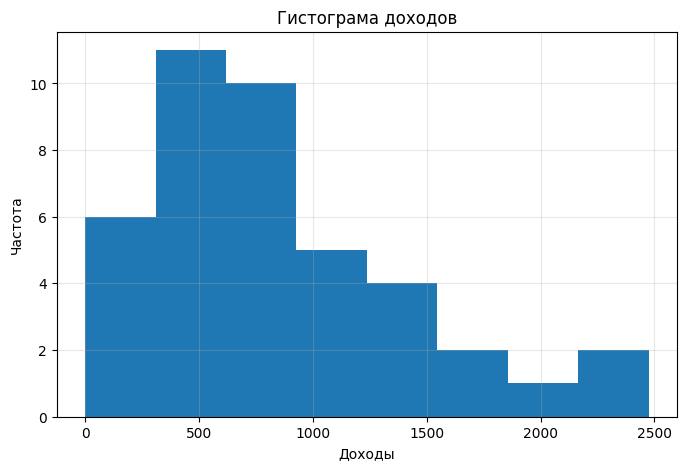

In [ ]:
plt.figure(figsize=(8, 5))

plt.hist(df['revenue'], bins = 8)

plt.title('Гистограма доходов')
plt.xlabel('Доходы')
plt.ylabel('Частота')

plt.grid(alpha = 0.3)

# plt.savefig("homeworks/HW02/figures/fig_1.png", dpi = 300, bbox_inches = 'tight')

plt.show()




### 2. boxplot для количественного признака

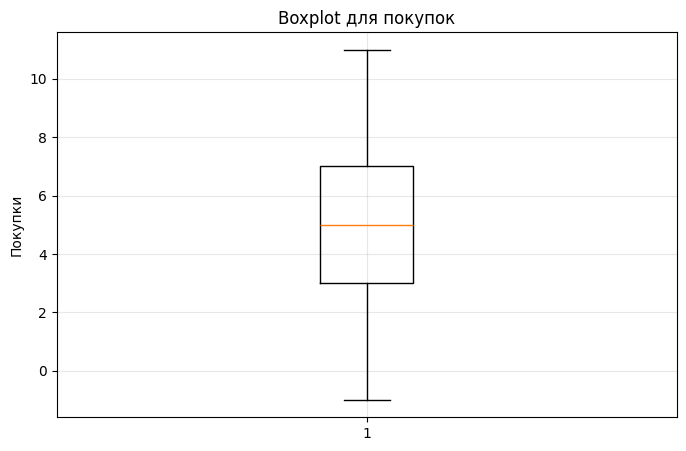

In [ ]:
plt.figure(figsize=(8, 5))
plt.boxplot(df['purchases'], vert = True)

plt.title('Boxplot для покупок')
plt.ylabel('Покупки')

plt.grid(alpha = 0.3)

# plt.savefig("homeworks/HW02/figures/fig_21.png", dpi = 300, bbox_inches = 'tight')

plt.show()

<Figure size 800x500 with 0 Axes>

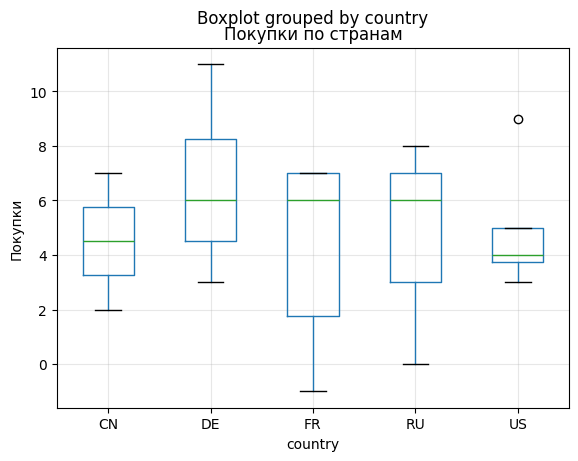

In [ ]:
plt.figure(figsize=(8, 5))

df.boxplot(column = 'purchases', by = 'country')

plt.title('Покупки по странам')
plt.ylabel('Покупки')

plt.grid(alpha = 0.3)

plt.savefig("homeworks/HW02/figures/fig_22.png", dpi = 300, bbox_inches = 'tight')

plt.show()

### 3. scatter-plot для пары количественных признаков

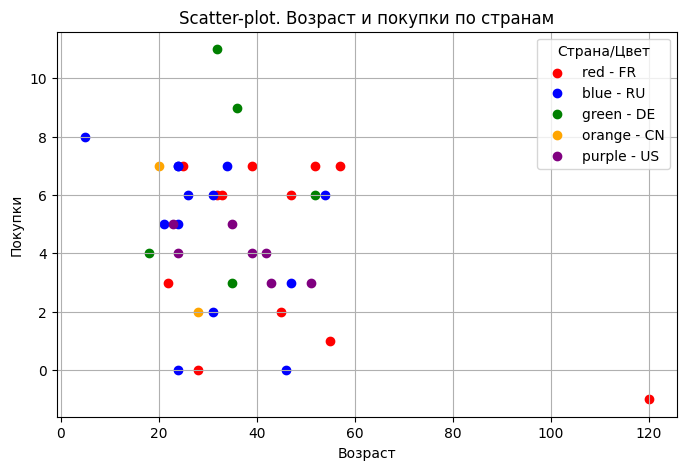

In [ ]:
plt.figure(figsize=(8, 5))

colors = {
    cat: color for cat, color in zip(df['country'].unique(), ['red', 'blue', 'green', 'orange', 'purple', 'brown'])
    
}

for cat in df['country'].unique():
    subset = df[df['country'] == cat]
    plt.scatter(subset['age'], subset['purchases'], label = f'{colors[cat]} - {cat}', color = colors[cat])

plt.title('Scatter-plot. Возраст и покупки по странам')
plt.xlabel('Возраст')
plt.ylabel('Покупки')
plt.legend(title = 'Страна/Цвет')

plt.grid('alpha = 0.3')

# plt.savefig("homeworks/HW02/figures/fig_3.png", dpi = 300, bbox_inches = 'tight')

plt.show()

### 4. Сохранить построенный график в папку homeworks/HW02/figures/